In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # increase dpi of the pics

In [3]:
plt.style.use('seaborn')

In [4]:
firsts = pd.read_csv('BI-Intern first_purchases.csv',
                   parse_dates=['User First Purchase Month'],
                   dayfirst=True, # Dates are in the format: D.M.YYYY (1.8.2020)
                   infer_datetime_format=True)
firsts.head()

,User First Purchase Month,First Purchase Product Line,User ID,Purchase ID,Venue ID
0,2020-05-01,Restaurant,57b48aece14f6d64522f8c5f,5ec6b23c96741b6db6266639,5d7a32a73b546fccd88a05e9
1,2020-05-01,Restaurant,59f4803cdf196473b7fc124d,5ec6be1e712a4248e67d2bf0,5cd16542c7420059cc10b792
2,2020-05-01,Restaurant,5a427fbbea63d5000aff0ade,5ec7f07674bbff7edcb5be0d,5e7bce9ae360062306b4a233
3,2020-05-01,Restaurant,5a8c70b58fac51000b2ca9d8,5eac48651db7a19612824809,5e6ce90a7455f89bbb00be37
4,2020-05-01,Restaurant,5a9efa9bab3442000c2ba457,5eca9ed670a4dafe5de07698,5ea18277857aaa1b337ee201


In [5]:
firsts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71257 entries, 0 to 71256
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   User First Purchase Month    71257 non-null  datetime64[ns]
 1   First Purchase Product Line  71257 non-null  object        
 2   User ID                      71257 non-null  object        
 3   Purchase ID                  71257 non-null  object        
 4   Venue ID                     71257 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.7+ MB


In [6]:
firsts.describe(exclude=['datetime']).transpose()

,count,unique,top,freq
First Purchase Product Line,71257,2,Restaurant,70822
User ID,71257,71257,5c7bfd5c82dbbf000b5aee8a,1
Purchase ID,71257,71257,5f0b4f322948a33558541c70,1
Venue ID,71257,1407,5e7dc5c6d12956517345e7d0,1351


In [7]:
purchases = pd.read_csv('BI-Intern purchases.csv',
                   parse_dates=['Purchases Time Delivered'],
                   dayfirst=True,
                   infer_datetime_format=True)

purchases.head()

,Purchases Time Delivered,Product line,User ID,Purchase ID,Venue ID
0,2020-08-01,Restaurant,55080d6585f6661a3b37f7a5,5f3d81ef6cce0eeb05225f98,5e8b2c8be050b99f26647804
1,2020-08-01,Restaurant,55080d6585f6661a3b37f7a5,5f3c11f5a90667e766b04c19,5e8b2c8be050b99f26647804
2,2020-07-01,Retail store,556202537f84a43ac29ec7cb,5f0aec594c3cbeb4049ea36a,5ec2ab4401f812138e435c89
3,2020-07-01,Retail store,556202537f84a43ac29ec7cb,5f184a3c88046da058c5ed1d,5ec2ab4401f812138e435c89
4,2020-05-01,Restaurant,57b48aece14f6d64522f8c5f,5ecf98f34d3d68dc996dad7a,5cb4425ae93cce000d20612f


In [8]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298714 entries, 0 to 298713
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Purchases Time Delivered  298714 non-null  datetime64[ns]
 1   Product line              298714 non-null  object        
 2   User ID                   298714 non-null  object        
 3   Purchase ID               298714 non-null  object        
 4   Venue ID                  298714 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 11.4+ MB


In [9]:
purchases.describe(exclude=['datetime']).transpose()

,count,unique,top,freq
Product line,298714,2,Restaurant,287921
User ID,298714,74568,5ec04f84d2868704abb52f98,205
Purchase ID,298714,298714,5f3d5419f391d53b4787057a,1
Venue ID,298714,1503,5e77a370fee9ef1ba62d6454,4602


There aren't null values in rows.

# Data cleaning and normalization

We are going to attach user to cohort, based on the "first purchase" dataframe.
There could be purchases, for which user is not presented in the "first purchase" dataframe. We want to filter them out, to be able to attach each purchase's user to the cohort.

In [10]:
missing = purchases[~purchases['User ID'].isin(firsts['User ID'])]['Purchase ID']

if missing.nunique() > 0:
    print("There exist {} purchases, for which User ID not presented in the first purchases table".format(missing.nunique()))

# Filter out incorrect purchases
purchases = purchases[~purchases['Purchase ID'].isin(missing)]

There exist 10145 purchases, for which User ID not presented in the first purchases table


In [11]:
firsts['month_normalized'] = firsts['User First Purchase Month'].dt.to_period('M')
purchases['month_normalized'] = purchases['Purchases Time Delivered'].dt.to_period('M')

# Restaurants

In [12]:
restaurant_purchases = purchases[purchases['Product line'] == 'Restaurant']

In [13]:
# Attach first purchase month to purchases as "month_normalized_cohort" column
restaurant_purchases = pd.merge(restaurant_purchases, firsts[['User ID', 'month_normalized']], on='User ID', how="left", suffixes=('', '_cohort'))

In [14]:
n_purchases = restaurant_purchases.groupby(['User ID'])['Purchase ID'].nunique()
total_customers = sum(cnt >= 1 for cnt in n_purchases)
returning_customers = sum(cnt >= 2 for cnt in n_purchases)
returning_ratio = returning_customers / total_customers
print(f'{100 * returning_ratio:.2f}% of "Restaurant" customers continue using the service after the first purchase')

51.04% of "Restaurant" customers continue using the service after the first purchase


**Distribution of number of purchases per customer**

Here we can see, that there are customers, who made more than 100 order. Could be that order were created in the system but not paid by the customer. Or incorrect data.

In [15]:
for k in n_purchases.keys():
    if (n_purchases[k] >= 150):
        print("{}: {}".format(k, n_purchases[k]))

5e92f86d8543cc9871d7057a: 172
5ebb171bdf7d418abd2b0da6: 168
5ec04f84d2868704abb52f98: 204
5ed37beb85374d378ed67758: 181
5ee54eb4113c1657c503a95f: 165
5eea584439f726a586098e28: 185


In [16]:
n_purchases.value_counts().sort_index()

1      34782
2      11427
3       5995
4       3904
5       2746
       ...  
168        1
172        1
181        1
185        1
204        1
Name: Purchase ID, Length: 119, dtype: int64

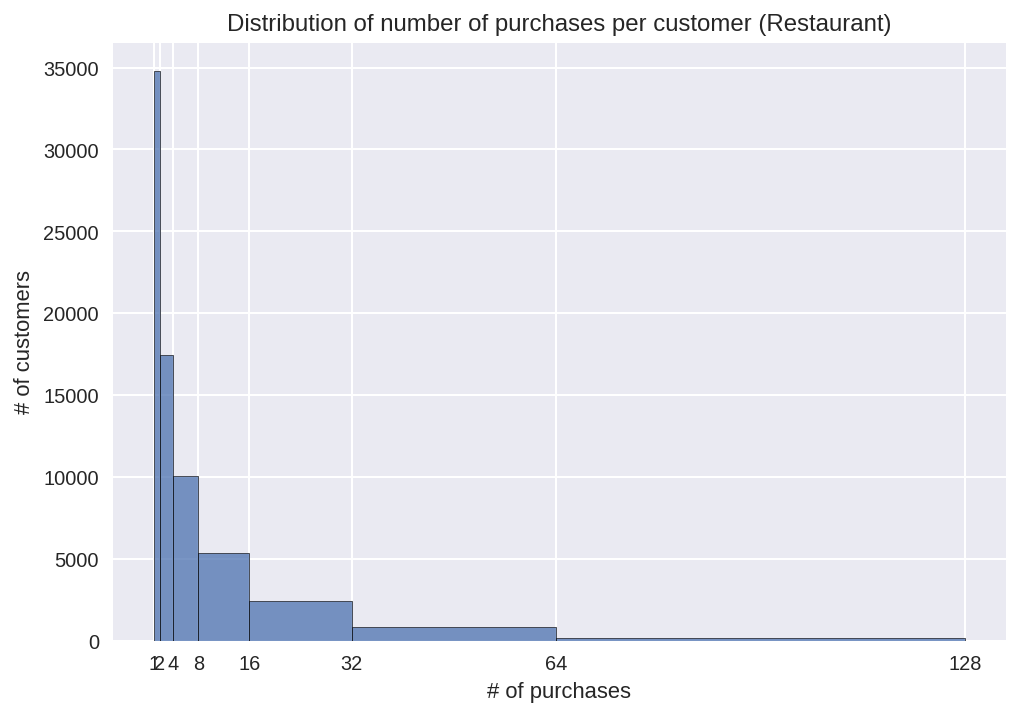

In [17]:
# https://seaborn.pydata.org/tutorial/distributions.html
ax = sns.histplot(n_purchases, bins=[1,2,4,8,16,32,64,128])
ax.set(title='Distribution of number of purchases per customer (Restaurant)',
       xlabel='# of purchases', 
       ylabel='# of customers',
       xticks=[1,2,4,8,16,32,64,128]);
ax.figure.savefig('Distribution of number of purchases per customer (Restaurant).png', dpi=300)

In [18]:
cohort = restaurant_purchases.groupby(['month_normalized_cohort', 'month_normalized']) \
              .agg(n_customers=('User ID', 'nunique')) \
              .reset_index(drop=False)
# diff is number of months between since the first purchase (month_normalized - month_normalized_cohort)
# where month_normalized_cohort is the month of the first purchase
cohort['diff'] = (cohort.month_normalized-cohort.month_normalized_cohort).apply(lambda x: x.n)

In [19]:
pivot = cohort.pivot_table(index = 'month_normalized_cohort',
                                     columns = 'diff',
                                     values = 'n_customers')

In [20]:
pivot

diff,0,1,2,3,4,5
month_normalized_cohort,,,,,,
2020-05,16811.0,6078.0,4739.0,4459.0,4730.0,3429.0
2020-06,11248.0,3939.0,3358.0,3298.0,2290.0,NaN
2020-07,9080.0,3019.0,2710.0,1899.0,NaN,NaN
2020-08,9866.0,3419.0,2194.0,NaN,NaN,NaN
2020-09,16163.0,4630.0,NaN,NaN,NaN,NaN
2020-10,7803.0,NaN,NaN,NaN,NaN,NaN


In [21]:
# Devide each column by the zero-month-column to normalize data
first_month_customers = pivot.iloc[:,0]
retention_matrix = pivot.divide(first_month_customers, axis = 0)

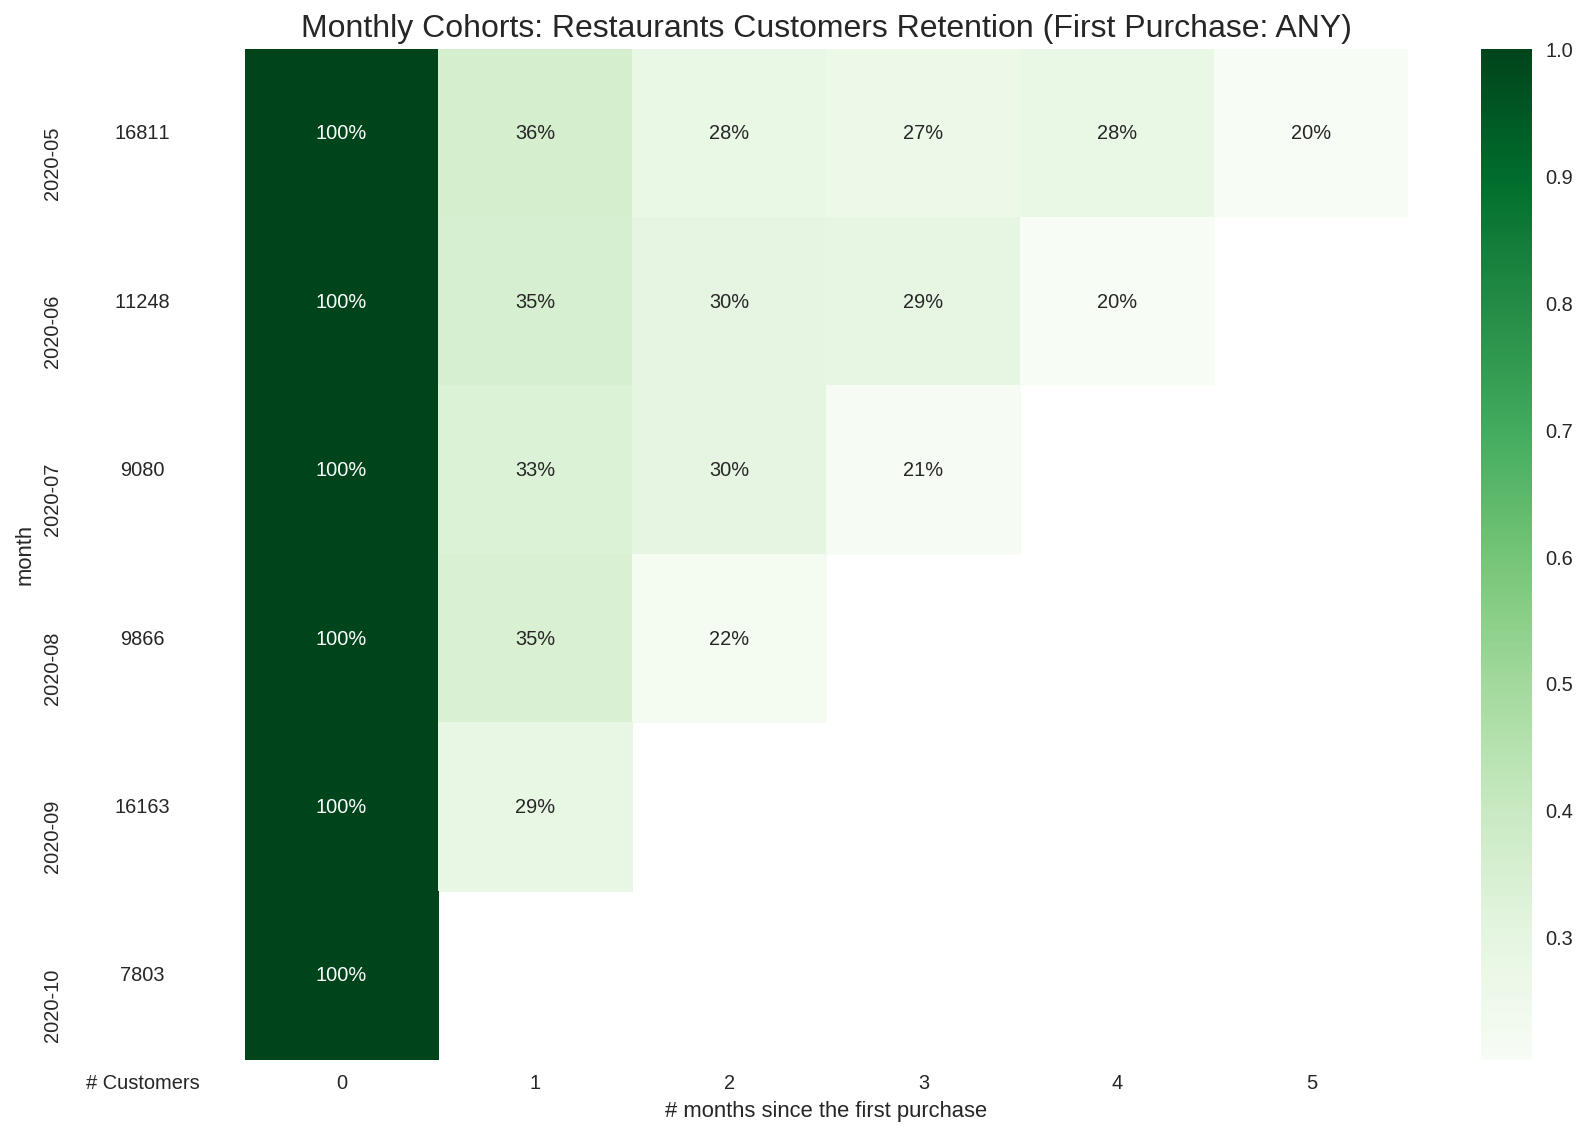

In [22]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='Greens',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Restaurants Customers Retention (First Purchase: ANY)', fontsize=16)
    ax[1].set(xlabel='# months since the first purchase',
              ylabel='')

    # cohort size    
    cohort_size_df = pd.DataFrame(first_month_customers).rename(columns={0: '# Customers'})
    cohort_size_df.index.rename('month', inplace=True)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    fig.savefig('Restaurants Customers Retention (First Purchase: ANY).png')

In [23]:
firsts_filtered = firsts[firsts['First Purchase Product Line'] == 'Restaurant']

In [24]:
purchases_filtered = purchases[purchases['User ID'].isin(firsts_filtered['User ID'])]

In [25]:
purchases_filtered = purchases_filtered[purchases_filtered['Product line'] == 'Restaurant']

In [26]:
purchases_filtered.describe().transpose()

<ipython-input-26-5a5b48e224ef>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  purchases_filtered.describe().transpose()


,count,unique,top,freq,first,last
Purchases Time Delivered,283750,6,2020-09-01 00:00:00,76935,2020-05-01,2020-10-01
Product line,283750,1,Restaurant,283750,NaT,NaT
User ID,283750,70822,5ec04f84d2868704abb52f98,204,NaT,NaT
Purchase ID,283750,283750,5f3d5419f391d53b4787057a,1,NaT,NaT
Venue ID,283750,1445,5e77a370fee9ef1ba62d6454,4571,NaT,NaT
month_normalized,283750,6,2020-09,76935,NaT,NaT


In [27]:
# Attach first purchase month to purchases as "month_normalized_cohort" column
purchases_filtered = pd.merge(purchases_filtered, firsts_filtered[['User ID', 'month_normalized']], on='User ID', how="left", suffixes=('', '_cohort'))

# Retail Stores

In [28]:
retstore_purchases = purchases[purchases['Product line'] == 'Retail store']

In [29]:
# Attach first purchase month to purchases as "month_normalized_cohort" column
retstore_purchases = pd.merge(retstore_purchases, firsts[['User ID', 'month_normalized']], on='User ID', how="left", suffixes=('', '_cohort'))

In [30]:
n_purchases = retstore_purchases.groupby(['User ID'])['Purchase ID'].nunique()
total_customers = sum(cnt >= 1 for cnt in n_purchases)
returning_customers = sum(cnt >= 2 for cnt in n_purchases)
returning_ratio = returning_customers / total_customers
print(f'{100 * returning_ratio:.2f}% of "Retail store" customers continue using the service after the first purchase')

39.06% of "Retail store" customers continue using the service after the first purchase


In [31]:
for k in n_purchases.keys():
    if (n_purchases[k] >= 30):
        print("{}: {}".format(k, n_purchases[k]))

5ea934ca1ba80db16b44ac2f: 52
5eada4393741b5599110c6b5: 52
5ebd45eb6ba9b45457052e3a: 30


In [32]:
n_purchases.value_counts().sort_index()

1     819
2     233
3     100
4      62
5      35
6      20
7      17
8      10
9       7
10      7
11      5
12      2
13      3
14      4
15      1
16      2
17      1
18      3
19      5
22      1
23      1
24      1
25      1
28      1
30      1
52      2
Name: Purchase ID, dtype: int64

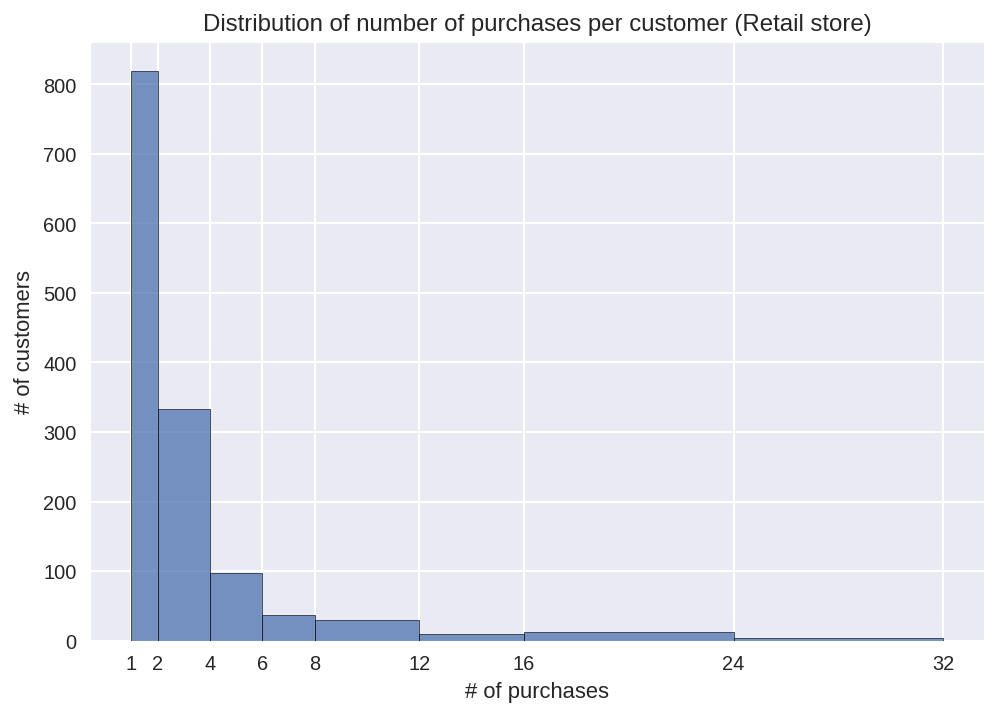

In [33]:
# https://seaborn.pydata.org/tutorial/distributions.html
ax = sns.histplot(n_purchases, bins=[1,2,4,6,8,12,16,24,32])
ax.set(title='Distribution of number of purchases per customer (Retail store)',
       xlabel='# of purchases', 
       ylabel='# of customers',
       xticks=[1,2,4,6,8,12,16,24,32]);
ax.figure.savefig('Distribution of number of purchases per customer (Retail store).png', dpi=300)

In [34]:
cohort = retstore_purchases.groupby(['month_normalized_cohort', 'month_normalized']) \
              .agg(n_customers=('User ID', 'nunique')) \
              .reset_index(drop=False)
# diff is number of months between since the first purchase (month_normalized - month_normalized_cohort)
# where month_normalized_cohort is the month of the first purchase
cohort['diff'] = (cohort.month_normalized-cohort.month_normalized_cohort).apply(lambda x: x.n)

In [35]:
pivot = cohort.pivot_table(index = 'month_normalized_cohort',
                                     columns = 'diff',
                                     values = 'n_customers')

In [36]:
pivot

diff,0,1,2,3,4,5
month_normalized_cohort,,,,,,
2020-05,161.0,86.0,52.0,56.0,87.0,54.0
2020-06,99.0,49.0,52.0,60.0,26.0,NaN
2020-07,112.0,58.0,67.0,31.0,NaN,NaN
2020-08,139.0,102.0,45.0,NaN,NaN,NaN
2020-09,284.0,91.0,NaN,NaN,NaN,NaN
2020-10,66.0,NaN,NaN,NaN,NaN,NaN


In [37]:
# Devide each column by the zero-month-column to normalize data
first_month_customers = pivot.iloc[:,0]
retention_matrix = pivot.divide(first_month_customers, axis = 0)

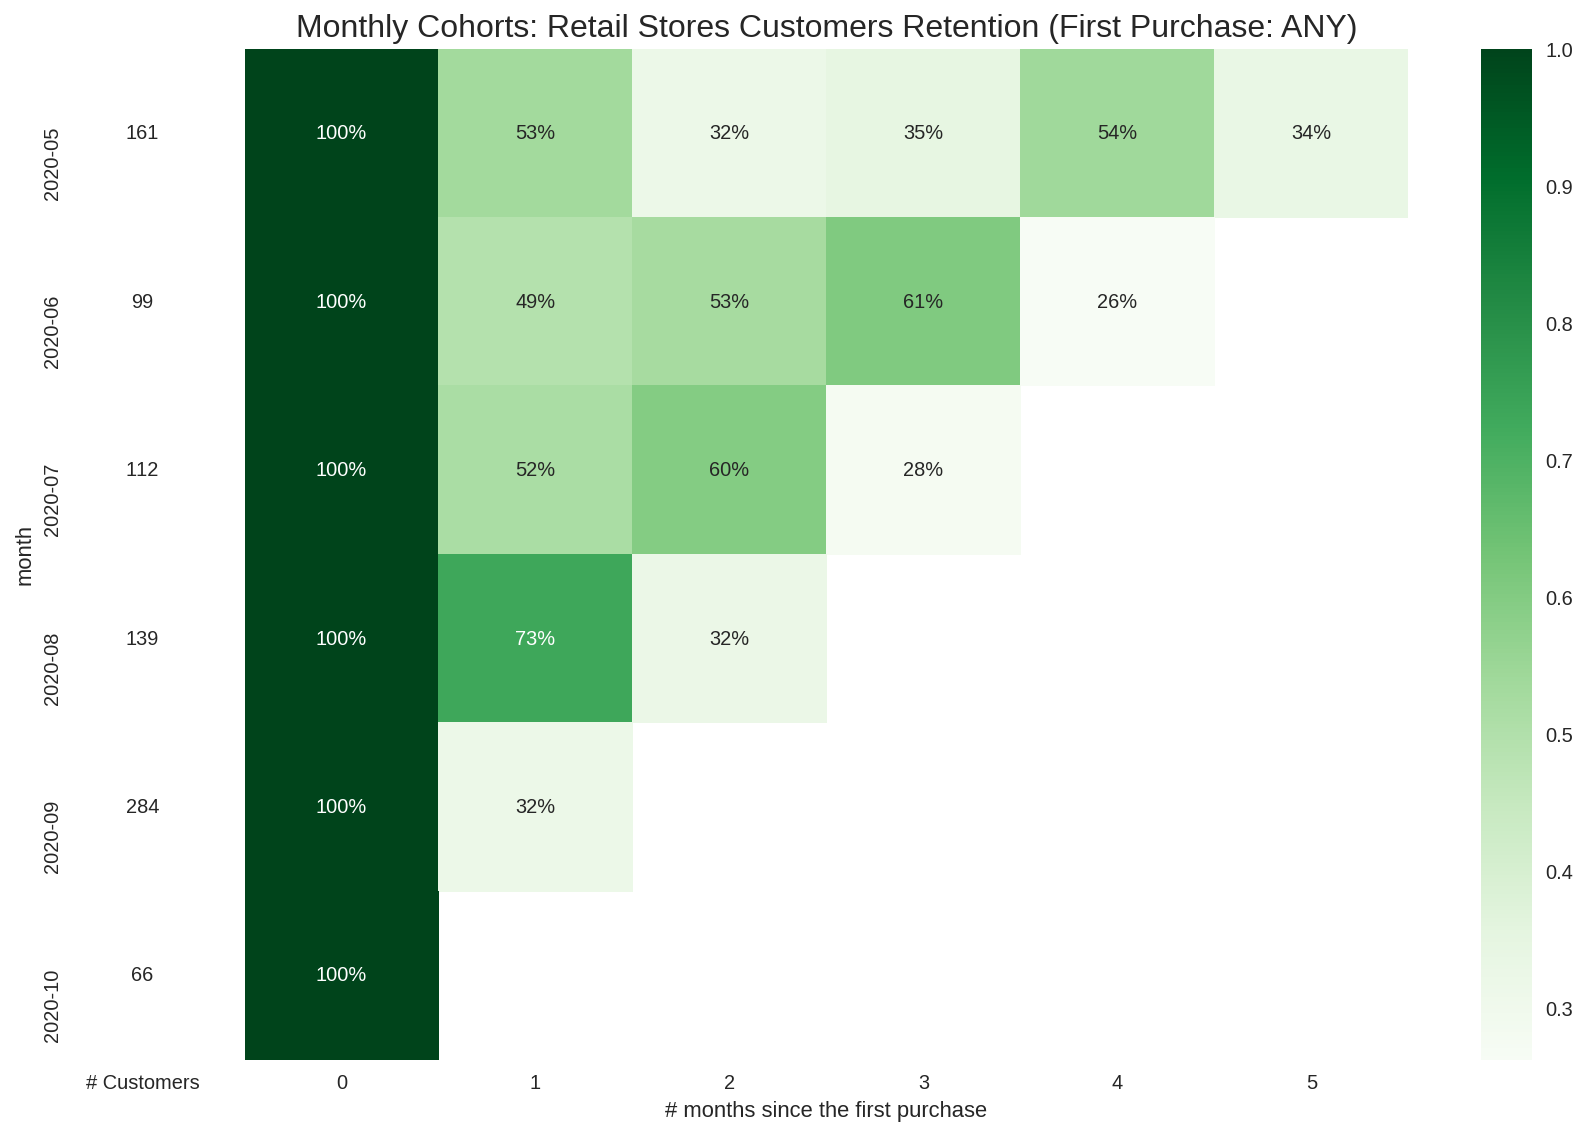

In [38]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='Greens',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Retail Stores Customers Retention (First Purchase: ANY)', fontsize=16)
    ax[1].set(xlabel='# months since the first purchase',
              ylabel='')

    # cohort size    
    cohort_size_df = pd.DataFrame(first_month_customers).rename(columns={0: '# Customers'})
    cohort_size_df.index.rename('month', inplace=True)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    fig.savefig('Retail Stores Customers Retention (First Purchase: ANY).png')